# Init model and params

In [1]:
import matplotlib.pyplot as plt
import sys, random
import numpy as np
import torch
from isegm.utils import vis, exp
from isegm.inference import utils
from isegm.inference.evaluation import evaluate_dataset, evaluate_sample
from isegm.inference.predictors import get_predictor
from isegm.inference.clicker import Clicker
EVAL_MAX_CLICKS = 20
MODEL_THRESH = 0.49
TARGET_IOU = 0.95

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cfg = exp.load_config_file('./config.yml', return_edict=True)
checkpoint_path = utils.find_checkpoint(cfg.INTERACTIVE_MODELS_PATH, 'coco_lvis_h18_itermask')
model = utils.load_is_model(checkpoint_path, device)

# Possible choices: 'NoBRS', 'f-BRS-A', 'f-BRS-B', 'f-BRS-C', 'RGB-BRS', 'DistMap-BRS'
brs_mode = 'f-BRS-B'
predictor = get_predictor(model, brs_mode, device, prob_thresh=MODEL_THRESH)



# Gen a click and make prediction

In [2]:
# selct a random image from dataset
DATASET = 'GrabCut'
dataset = utils.get_dataset(DATASET, cfg)
sample_id = random.sample(range(len(dataset)), 1)[0]
sample = dataset.get_sample(sample_id)
gt_mask = sample.gt_mask
predictor.original_image = None

In [3]:
# init mouse click
clicker = Clicker(gt_mask=gt_mask)
pred_mask = np.zeros_like(gt_mask)
prev_prediction = None
ious_list = []

[0.8947940947940948, 0.807002414625733, 0.9271058315334774, 0.9532220386302774]


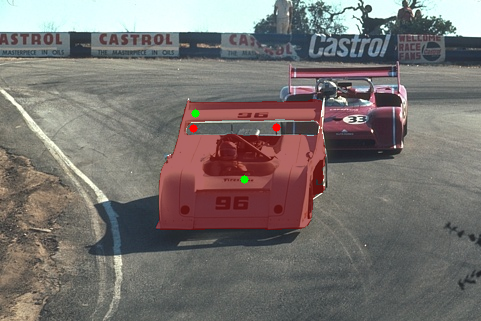

In [57]:
## run this block many times for continuous prediction
# gen a click and make prediction
clicker.make_next_click(pred_mask)

# get prediction
with torch.no_grad():
    img = sample.image
    predictor.set_input_image(img)
    pred_probs = predictor.get_prediction(clicker, prev_prediction)

# post precessing
prev_prediction = predictor.prev_prediction
pred_mask = pred_probs > MODEL_THRESH
iou = utils.get_iou(gt_mask, pred_mask)
ious_list.append(iou)
print(ious_list)

# draw prediction
from PIL import Image
draw = vis.draw_with_blend_and_clicks(sample.image, mask=pred_mask, clicks_list=clicker.clicks_list)
# plt.figure(figsize=(20,20))
# plt.imshow(draw)
# plt.show()
Image.fromarray(draw)


In [36]:
print(sample.image.shape)
print(prev_prediction.shape, prev_prediction.dtype)
print(sample.image.shape)
print(pred_mask.shape)
prev_prediction

(480, 640, 3)
torch.Size([1, 1, 480, 640]) torch.float32
(480, 640, 3)
(480, 640)


tensor([[[[0.0967, 0.0952, 0.0937,  ..., 0.1201, 0.1176, 0.1152],
          [0.1013, 0.0990, 0.0967,  ..., 0.1191, 0.1182, 0.1174],
          [0.1061, 0.1029, 0.0998,  ..., 0.1181, 0.1188, 0.1196],
          ...,
          [0.1188, 0.1269, 0.1354,  ..., 0.1213, 0.1148, 0.1087],
          [0.1190, 0.1267, 0.1348,  ..., 0.1214, 0.1150, 0.1090],
          [0.1192, 0.1265, 0.1342,  ..., 0.1215, 0.1153, 0.1093]]]])

In [37]:
sample.image

array([[[141,  92,  16],
        [144,  92,  17],
        [143,  91,  16],
        ...,
        [154,  97,  26],
        [150,  96,  26],
        [151,  97,  27]],

       [[142,  93,  17],
        [145,  93,  18],
        [145,  93,  18],
        ...,
        [153,  99,  25],
        [150,  98,  25],
        [149,  97,  24]],

       [[143,  93,  20],
        [146,  94,  21],
        [147,  95,  20],
        ...,
        [152, 100,  24],
        [149, 100,  24],
        [148,  99,  23]],

       ...,

       [[145,  97,  25],
        [147,  99,  27],
        [146, 103,  25],
        ...,
        [160, 100,  28],
        [158, 100,  27],
        [157,  99,  26]],

       [[144,  96,  24],
        [147,  99,  27],
        [147, 103,  28],
        ...,
        [160, 100,  28],
        [158, 100,  26],
        [157,  99,  25]],

       [[147,  92,  25],
        [151,  96,  29],
        [152, 102,  29],
        ...,
        [159, 101,  27],
        [158, 101,  24],
        [157, 100,  23]]